# Explore pylidc library objects

**Goal:** We want to use the `monai` library for medical imaging in order to build our models. However, the LIDC dataset is quite messy (e.g., multiple scan series within one folder, duplicate z position values). Thus, we most likely need a custom `monai.data.ImageReader` object, because the standard ITK reader will run into errors. The `pylidc` library deals with the quirks of the LIDC dataset out-of-the-box. Consequently, we want to explore whether we can use it for building a custom `ImageReader` object.

## Imports and configuration

In [1]:
import os
from pathlib import Path
import random

%matplotlib inline

import pandas as pd
import numpy as np
import pydicom as dicom
import pylidc as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
import monai
import itk

In [2]:
monai.config.print_config()

MONAI version: 0.4.0
Numpy version: 1.19.4
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0563a4467fa602feca92d91c7f47261868d171a1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.18.0
Pillow version: 8.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.8.2
ITK version: 5.1.2
tqdm version: 4.56.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
LIDC_DIR = Path("/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/")
DICOM_DIR = LIDC_DIR / "LIDC-IDRI"
PROC_DIR = LIDC_DIR / "processed"

In [4]:
print(LIDC_DIR.exists())
print(DICOM_DIR.exists())
PROC_DIR.mkdir(parents=True, exist_ok=True)

True
True


## What is required for building a custom ImageReader?

In [5]:
??monai.data.ImageReader

The methods need to be implemented when inheriting from the abstract `ImageReader` class:

- `verify_suffix`: This should be relatively trivial.
- `read`: This method requires a list of files (or a patient ID) and returns the raw files.
- `get_data`: This method gets the raw files and returns a numpy array of image data and a dictionary of meta data.

Let's start by exploring how we can extract a numpy array of image data from the `pylidc.Scan` class.

## How can we extract the required pixel array?

In [6]:
patient_list= [f for f in os.listdir(DICOM_DIR) if not f.startswith('.')]
patient_list.sort()

In [7]:
# remove .*.dcm files that were created on download from TCIA
# these files hinder loading the volume using pylidc
#for pid in patient_list:
#    !rm {DICOM_DIR}/{pid}/**/.*.dcm

In [8]:
pid = patient_list[0]
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

In [9]:
??scan.to_volume

**Note:** Rescaling is applied by pylidc when creating the volume. Thus, documentation on the [pylidc website](https://pylidc.github.io/_modules/pylidc/Scan.html#Scan.to_volume) is not current!

Loading dicom files ... This may take a moment.


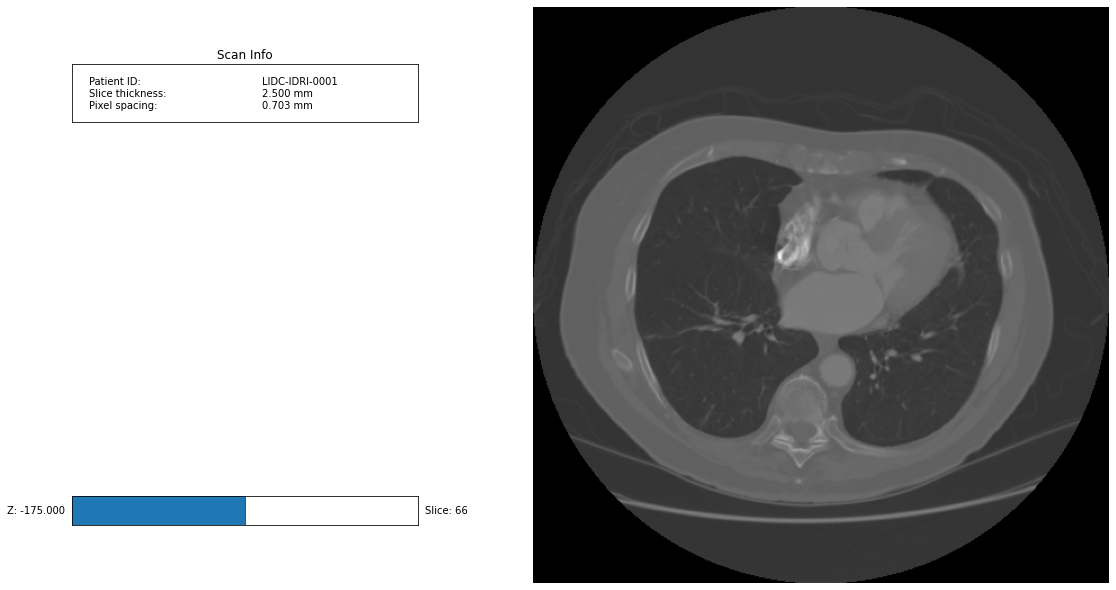

In [10]:
scan.visualize()
plt.show()

Loading dicom files ... This may take a moment.


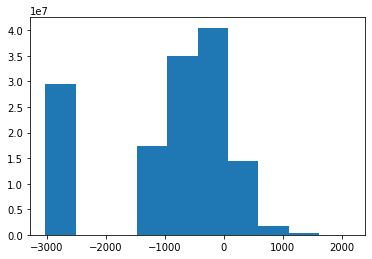

Loading dicom files ... This may take a moment.


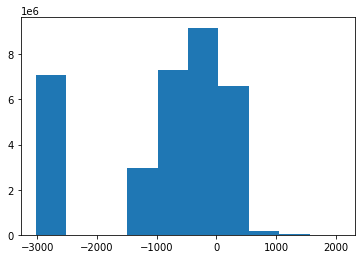

Loading dicom files ... This may take a moment.


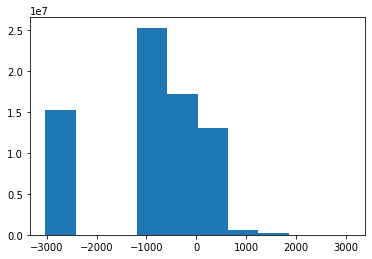

Loading dicom files ... This may take a moment.


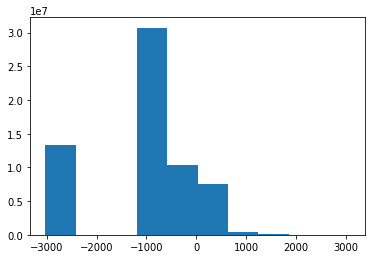

Loading dicom files ... This may take a moment.


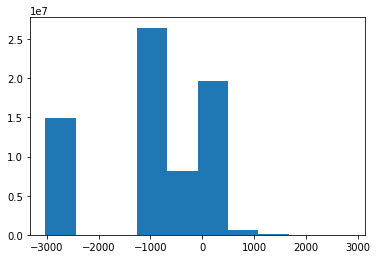

Loading dicom files ... This may take a moment.


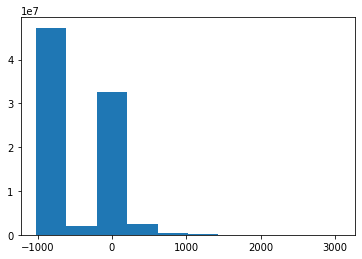

Loading dicom files ... This may take a moment.


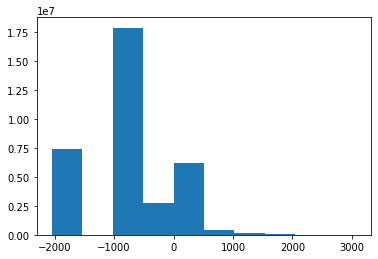

Loading dicom files ... This may take a moment.


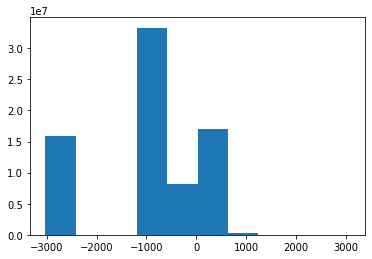

Loading dicom files ... This may take a moment.


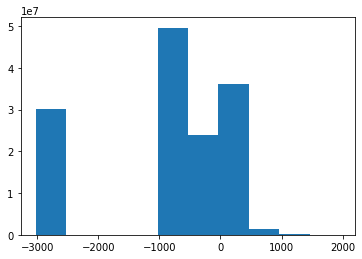

Loading dicom files ... This may take a moment.


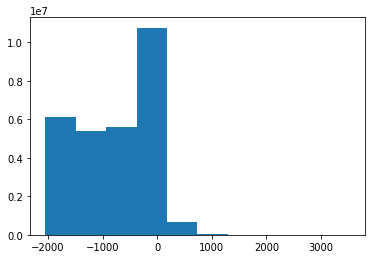

In [11]:
for pid in random.sample(patient_list, 10):
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
    vol = scan.to_volume()
    plt.hist(vol.flatten())
    plt.show()

Pixel distributions look reasonable for this small random sample. Thus, we have a way for extracting the required numpy array.

## How can we extract the required metadata?

### What metadata is required?

In order for image transformations to work in monai, images need to be accompanied with certain metadata. In detail, the following attributes are required (see [docs](https://docs.monai.io/en/latest/data.html#itkreader)]:

- *affine*
- *original_affine*
- *spatial_shape*

### What metadata does pylidc provide?

In [12]:
??scan

Luckily, the `Scan` class extracts some metadata from the raw DICOM on object creation:

In [13]:
def print_meta(scan):
    attrs = ["study_instance_uid", 
             "series_instance_uid", 
             "patient_id", 
             "slice_thickness",
             "slice_zvals",
             "slice_spacing",
             "pixel_spacing",
             "contrast_used",
            ]
    for attr in attrs:
        print(f"{attr}:", getattr(scan, attr))

In [14]:
print_meta(scan)

study_instance_uid: 1.3.6.1.4.1.14519.5.2.1.6279.6001.137094437164923904545127071746
series_instance_uid: 1.3.6.1.4.1.14519.5.2.1.6279.6001.205174485766424333452131788504
patient_id: LIDC-IDRI-0773
slice_thickness: 3.0
slice_zvals: [1394.5 1397.5 1400.5 1403.5 1406.5 1409.5 1412.5 1415.5 1418.5 1421.5
 1424.5 1427.5 1430.5 1433.5 1436.5 1439.5 1442.5 1445.5 1448.5 1451.5
 1454.5 1457.5 1460.5 1463.5 1466.5 1469.5 1472.5 1475.5 1478.5 1481.5
 1484.5 1487.5 1490.5 1493.5 1496.5 1499.5 1502.5 1505.5 1508.5 1511.5
 1514.5 1517.5 1520.5 1523.5 1526.5 1529.5 1532.5 1535.5 1538.5 1541.5
 1544.5 1547.5 1550.5 1553.5 1556.5 1559.5 1562.5 1565.5 1568.5 1571.5
 1574.5 1577.5 1580.5 1583.5 1586.5 1589.5 1592.5 1595.5 1598.5 1601.5
 1604.5 1607.5 1610.5 1613.5 1616.5 1619.5 1622.5 1625.5 1628.5 1631.5
 1634.5 1637.5 1640.5 1643.5 1646.5 1649.5 1652.5 1655.5 1658.5 1661.5
 1664.5 1667.5 1670.5 1673.5 1676.5 1679.5 1682.5 1685.5 1688.5 1691.5
 1694.5 1697.5 1700.5 1703.5 1706.5 1709.5 1712.5 1715.5 1

### What metadata is used in monai when reading DICOM images?

Let's check if this metadata is sufficient for monai. The default ImageReader for DICOM files is the `ITKReader` (which we will lean on when implementing our ImageReader). In its implementation, we can see what metadata it uses for constructing the required attributes.

In [22]:
??monai.data.ITKReader

The ITKReader extracts three attributes from the image, namely origin, spacing and direction. These are then used for constructing the affine property. Spatial shape is inferred directly from the image.

In [55]:
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == "LIDC-IDRI-0773").first()

In [57]:
path = Path(scan.get_path_to_dicom_files())
dcm = sorted(path.glob('*.dcm'))[0]
dcm

PosixPath('/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/LIDC-IDRI/LIDC-IDRI-0773/01-01-2000-71746/5198.000000-88504/1-001.dcm')

In [58]:
ir = monai.data.ITKReader()

In [59]:
img = ir.read(str(dcm))

In [60]:
def print_img_attrs(img):
    print("Origin:\n", np.asarray(img.GetOrigin()))
    print("Spacing:\n", np.asarray(img.GetSpacing()))
    print("Direction:\n", itk.array_from_matrix(img.GetDirection()))
print_img_attrs(img)

Origin:
 [-186.7187 -192.1875 1718.5   ]
Spacing:
 [0.72 0.72 1.  ]
Direction:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [63]:
print(scan.slice_spacing, scan.slice_thickness)

3.0 3.0


In [62]:
dimg = dicom.dcmread(dcm)
dimg

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.199778636721322811862331831183
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.19977

We can see that:

- Origin = Patient Position
- Spacing = Pixel Spacing (+ default of 1 for z dimension???)
- Direction = 3D diagonal matrix with values of 1 (basically image orientation + third row)

We should be able to extract these elements without relying on ITK.